Calculating the mld depth using interpolation of the s-levels in the Norkyst dataset. This creates more continous depths and might make the mld calculations more accurate than using a transformation method from s_rho to z_rho. This notebook is to visualize the differences and compare these two methods of calculating the mld. I will use the xarray interpolation feature as recommended by a colleauge. Ill try using a linear method. If this interpolation lacks effiency, I might consider using xroms and sgrid instead, but I will try to stick with xarray.

In [66]:
from script_mld import dens
from script_mld import transformation
from script_mld import MLD
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

In [16]:
#example area
ds_2024 = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc').isel( time = 0, X = 360, Y = 760)
ds_2024.head()

<xarray.Dataset> Size: 364B
Dimensions:           (s_rho: 5, s_w: 5)
Coordinates:
    time              datetime64[ns] 8B 2024-03-30
  * s_rho             (s_rho) float64 40B -0.9799 -0.9403 ... -0.8634 -0.8261
    X                 float64 8B 2.88e+05
    Y                 float64 8B 6.08e+05
  * s_w               (s_w) float64 40B -1.0 -0.96 -0.9208 -0.8823 -0.8446
    lon               float64 8B ...
    lat               float64 8B ...
Data variables: (12/18)
    Uwind_eastward    float32 4B ...
    Vwind_northward   float32 4B ...
    zeta              float32 4B ...
    ubar_eastward     float32 4B ...
    vbar_northward    float32 4B ...
    u_eastward        (s_rho) float32 20B ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 40B ...
    Cs_w              (s_w) float64 40B ...
    h                 float32 4B ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [69]:
# Depths to interpolate to
zlevs = np.arange(0,51,1)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(52,102,2), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(105,305,5), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(520,1020,20), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(1050,3050,50), axis =0)

temp = ds_2024.temperature
salinity = ds_2024.salinity
s_rho = ds_2024.s_rho


f = interp1d(s_rho, temp, bounds_error=False, fill_value='extrapolate', kind = 'linear') #guessing unknown values
temp_int = f(zlevs)
print(temp_int)
f_s = interp1d(s_rho, salinity, bounds_error=False, fill_value='extrapolate', kind = 'linear') #guessing unknown values
salinity_int = f_s(zlevs)
#f_d = interp1d(s_rho, ds_2024.s_w, bounds_error=False, fill_value='extrapolate', kind = 'linear')



[ 6.93552768e+00  6.83923837e+00  6.74294905e+00  6.64665973e+00
  6.55037042e+00  6.45408110e+00  6.35779178e+00  6.26150246e+00
  6.16521315e+00  6.06892383e+00  5.97263451e+00  5.87634520e+00
  5.78005588e+00  5.68376656e+00  5.58747725e+00  5.49118793e+00
  5.39489861e+00  5.29860930e+00  5.20231998e+00  5.10603066e+00
  5.00974135e+00  4.91345203e+00  4.81716271e+00  4.72087340e+00
  4.62458408e+00  4.52829476e+00  4.43200545e+00  4.33571613e+00
  4.23942681e+00  4.14313749e+00  4.04684818e+00  3.95055886e+00
  3.85426954e+00  3.75798023e+00  3.66169091e+00  3.56540159e+00
  3.46911228e+00  3.37282296e+00  3.27653364e+00  3.18024433e+00
  3.08395501e+00  2.98766569e+00  2.89137638e+00  2.79508706e+00
  2.69879774e+00  2.60250843e+00  2.50621911e+00  2.40992979e+00
  2.31364048e+00  2.21735116e+00  2.12106184e+00  1.92848321e+00
  1.73590457e+00  1.54332594e+00  1.35074731e+00  1.15816867e+00
  9.65590040e-01  7.73011406e-01  5.80432773e-01  3.87854139e-01
  1.95275505e-01  2.69687

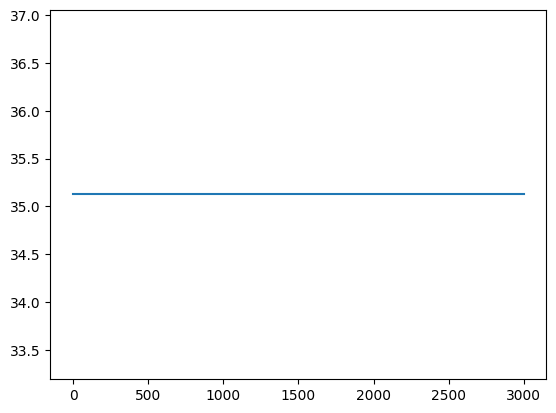

In [65]:
plt.plot(zlevs, salinity_int)

In [35]:
"""
#zlevs = zlevs[np.where(zlevs<=np.max(ds_2024.depth))]
zlevs = np.array(zlevs)*-1.

#interpolation of zlevels using xarray int & zelvs from Kjerstis code
z = ds_2024["s_rho"].interp(s_rho = zlevs, method = "linear")
z_i = z["s_rho"].values
#print(z_i.shape)
#print(z_i)

temp_i = ds_2024["temperature"].interp(s_rho = zlevs, ds_2024.temperature, method = "linear")
salinity_i = ds_2024["salinity"].interp(s_rho = zlevs, method = "linear")

temp_i = temp_i["s_rho"].values
salinity_i = salinity_i["s_rho"].values

if np.all(temp_i) != np.all(salinity_i):
    print(f'Salinity and temp are not the same values')
else:
    print(f'They are the same')

print(f"Original temp values: {ds_2024.temperature.values} and new temp values: {temp_i}")
"""

'\n#zlevs = zlevs[np.where(zlevs<=np.max(ds_2024.depth))]\nzlevs = np.array(zlevs)*-1.\n\n#interpolation of zlevels using xarray int & zelvs from Kjerstis code\nz = ds_2024["s_rho"].interp(s_rho = zlevs, method = "linear")\nz_i = z["s_rho"].values\n#print(z_i.shape)\n#print(z_i)\n\ntemp_i = ds_2024["temperature"].interp(s_rho = zlevs, ds_2024.temperature, method = "linear")\nsalinity_i = ds_2024["salinity"].interp(s_rho = zlevs, method = "linear")\n\ntemp_i = temp_i["s_rho"].values\nsalinity_i = salinity_i["s_rho"].values\n\nif np.all(temp_i) != np.all(salinity_i):\n    print(f\'Salinity and temp are not the same values\')\nelse:\n    print(f\'They are the same\')\n\nprint(f"Original temp values: {ds_2024.temperature.values} and new temp values: {temp_i}")\n'

In [3]:
ds_2024.head()

<xarray.Dataset> Size: 364B
Dimensions:           (s_rho: 5, s_w: 5)
Coordinates:
    time              datetime64[ns] 8B 2024-03-30
  * s_rho             (s_rho) float64 40B -0.9799 -0.9403 ... -0.8634 -0.8261
    X                 float64 8B 2.88e+05
    Y                 float64 8B 6.08e+05
  * s_w               (s_w) float64 40B -1.0 -0.96 -0.9208 -0.8823 -0.8446
    lon               float64 8B ...
    lat               float64 8B ...
Data variables: (12/18)
    Uwind_eastward    float32 4B ...
    Vwind_northward   float32 4B ...
    zeta              float32 4B ...
    ubar_eastward     float32 4B ...
    vbar_northward    float32 4B ...
    u_eastward        (s_rho) float32 20B ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 40B ...
    Cs_w              (s_w) float64 40B ...
    h                 float32 4B ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [71]:
pot_dens = dens(temp_int, salinity_int)
#pot_dens = pot_dens.values

/lustre/storeB/project/fou/hi/foccus/malene/ocean-ai/plot/dens_func.py:45: RuntimeWarning: invalid value encountered in power
  return SMOW + RB*S + RC*(S**1.5) + d0*S*S
/lustre/storeB/project/fou/hi/foccus/malene/ocean-ai/plot/dens_func.py:74: RuntimeWarning: invalid value encountered in sqrt
  SR = S**0.5


In [72]:
MLD(pot_dens=pot_dens, z = zlevs)

The first depth where the treshold is exceeded is: 0


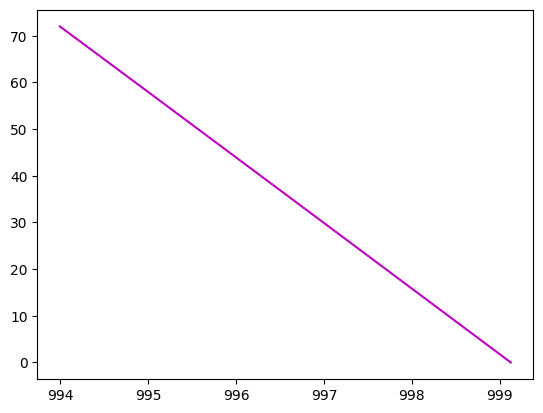

In [73]:
plt.plot(pot_dens,zlevs, color = "m")